In [1]:
import os
import os.path as osp
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets.dataset import load_data#, CLASS_MAP
import models.models as models
from sklearn.model_selection import GroupShuffleSplit
import argparse
import csv

import utils.my_trainer as trainer
import utils.train_result as train_result
from utils.data_class import BrainDataset
import utils.confusion as confusion
import torchio as tio
import numpy as np
from PIL import Image

In [2]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image, output):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5))
    X, Y = 2, 8
    
    for i in range(8):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        ax1.set_title("original"+str(imgplot), fontsize=12)
        img = np.flip(image[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)
        plt.imshow(img, cmap="gray")
        plt.tick_params(labelsize=8)
        
        ax2 = fig.add_subplot(X, Y, imgplot+Y)
        ax2.set_title("output"+str(imgplot), fontsize=12) 
        out = np.flip(output[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)
        plt.imshow(out, cmap="gray")
        ax_pos = ax2.get_position()
        mse_value = round(mean_squared_error(img, out), 3)
        ssim_value = round(ssim(img, out), 3)
        fig.text(ax_pos.x1 - 0.065, ax_pos.y1 - 0.4, " mse: " + str(mse_value), size=12)
        fig.text(ax_pos.x1 - 0.065, ax_pos.y1 - 0.45, "ssim: " + str(ssim_value), size=12)
        plt.tick_params(labelsize=8)
    #fig.tight_layout()
    
    plt.show()

In [3]:
# calculate ssim and mse

def calc_ssim(image, output):
    mse_sum = 0
    ssim_sum = 0
    for i in range(len(image)):
        img = np.flip(image[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)
        out = np.flip(output[i].numpy().reshape(80, 96, 80).transpose(1,2,0)[50],0)

        mse_value = mean_squared_error(img, out)
        ssim_value = ssim(img, out)

        mse_sum += mse_value
        ssim_sum += ssim_value
    return mse_sum / len(image), ssim_sum / len(image)

In [9]:
def parser():
    parser = argparse.ArgumentParser(description="example")
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--epoch", type=int, default=100)
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--log", type=str, default="output")
    parser.add_argument("--n_train", type=float, default=0.8)
    parser.add_argument("--train_or_loadnet", type=str, default="loadnet")    # train or loadnet
    parser.add_argument("--model", type=str, default="CAE")     # VAE or CAE
    args = parser.parse_args(args=['--model','Cae_nearest'])
    return args


# TorchIO
class ImageTransformio():
    def __init__(self):
        self.transform = {
            "train":tio.Compose([
                #tio.RandomBlur(),
                #tio.RandomBiasField(coefficients=1),
                # tio.RandomAffine(scales=(0.9, 1.2), degrees=10, isotropic=True, center="image", default_pad_value="mean", image_interpolation='linear'),
                #tio.ZNormalization(),
                # tio.RescaleIntensity((0, 1))#, in_min_max=(0.1, 255))
                
            ]),
            "val":tio.Compose([
                #tio.ZNormalization(),
                # tio.RescaleIntensity((0, 1))#, in_min_max=(0.1, 255))
            ])
        } 
    def __call__(self, img, phase="train"):
        # img_t = torch.unsqueeze(torch.tensor(img), 0) 
        img_t = torch.tensor(img)
        return self.transform[phase](img_t)
        
def load_dataloader(n_train_rate, batch_size):

    data = load_data(kinds=["ADNI2-2"], classes=["CN", "AD"], unique=False)

    pids=[]
    for i in range(len(data)):
        pids.append(data[i]["pid"])
    gss = GroupShuffleSplit(test_size=1-n_train_rate, random_state=0)
    train_idx, val_idx = list(gss.split(data, groups=pids))[0]
    train_data=data[train_idx]
    val_data=data[val_idx]

    #train_datadict, val_datadict = train_test_split(dataset, test_size=1-n_train_rate, shuffle=True)

    train_dataset = BrainDataset(data_dict=train_data, transform=ImageTransformio(), phase="train")
    val_dataset = BrainDataset(data_dict=val_data, transform=ImageTransformio(), phase="val")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=False)

    return train_dataloader, val_dataloader

#os.makedirs(log_path, exist_ok=True)
#os.makedirs(log_path + "csv/", exist_ok=True)

In [10]:
torch.manual_seed(0)
args = parser()
args.log

'output'

device: cuda:1


Cae_nearest


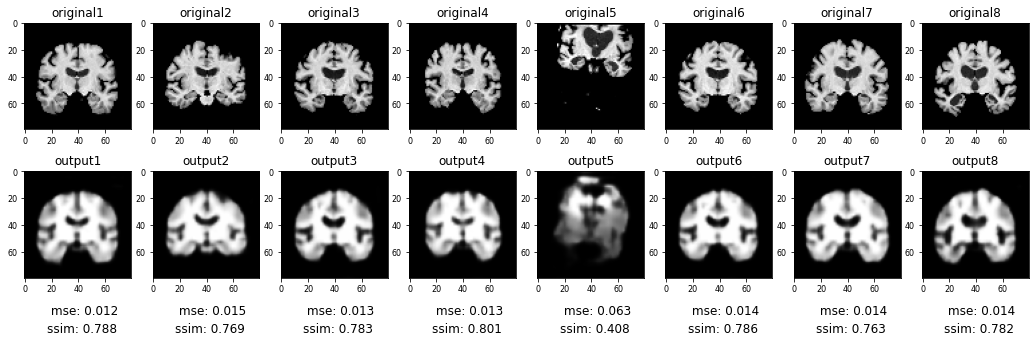

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() and True else "cpu")
print("device:", device)    

train_loader, val_loader = load_dataloader(args.n_train, args.batch_size)

if args.model == "VAE":
    print("VAE")
    log_path = "./logs/" + args.log + "_vae/"

    os.makedirs(log_path, exist_ok=True)

    net = models.Vae()

    net.load_state_dict(torch.load(log_path+'vae_weight.pth'))

    val_loader_iter = iter(val_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output, _, _ = net.forward(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)
    mse, ssim = calc_ssim(image, output)
    print(mse, ssim)
    # pil_img = Image.fromarray(np.flip(output[0].numpy().reshape(80, 80, 80).transpose(1,2,0)[50],0) * 255)
    # pil_img = pil_img.convert("L")
    #pil_img.save(log_path+"img/vae_output_img.jpg")


elif args.model == "CAE":
    print("CAE")
    log_path = "./logs/" + args.log + "_cae/"
    os.makedirs(log_path, exist_ok=True)

    net = models.Cae()
    net.load_state_dict(torch.load(log_path+'cae_weight.pth'))

    val_loader_iter = iter(train_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output = net(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)
    
elif args.model == "Caee":
    print("Caee")
    log_path = "./logs/" + args.log + "_caee/"
    os.makedirs(log_path, exist_ok=True)

    net = models.Caee()
    net.load_state_dict(torch.load(log_path+'caee_weight.pth'))

    val_loader_iter = iter(train_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output = net(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)
    
elif args.model == "Caee_avgpool":
    print("Caee_avgpool")
    log_path = "./logs/" + args.log + "_caee_avgpool/"
    os.makedirs(log_path, exist_ok=True)

    net = models.Caee()
    net.load_state_dict(torch.load(log_path+'caee_avgpool_weight.pth'))

    val_loader_iter = iter(train_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output = net(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)
    
elif args.model == "Cae_avgpool":
    print("Cae_avgpool")
    log_path = "./logs/" + args.log + "_cae_avgpool/"
    os.makedirs(log_path, exist_ok=True)

    net = models.Cae()
    net.load_state_dict(torch.load(log_path+'cae_avgpool_weight.pth'))

    val_loader_iter = iter(train_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output = net(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)

elif args.model == "Cae_nearest":
    print("Cae_nearest")
    log_path = "./logs/" + args.log + "_cae_nearest/"
    os.makedirs(log_path, exist_ok=True)

    net = models.Cae()
    net.load_state_dict(torch.load(log_path+'cae_nearest_weight.pth'))

    val_loader_iter = iter(train_loader)
    image, _ = next(val_loader_iter)
    image = image.to(device)
    net.to(device)
    net.eval()
    with torch.no_grad():
        output = net(image)

    image = image.cpu()
    output = output.cpu()

    show_image(image, output)

In [12]:
encoder_output_list = []
label_list = []

net.to(device)
net.eval()
train_loader_iter = iter(train_loader)

for image, label in train_loader_iter:
    image = image.to(device)
    
    with torch.no_grad():
        encoder_output = net.encoder(image)
    encoder_output = encoder_output.cpu()
    label = label.cpu()
    encoder_output_list.append(encoder_output)
    label_list.append(label)

print(len(encoder_output_list))
print(len(label_list))

83
83


In [13]:

import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_embedded_list = []
color_list = []

#t-SNEで次元削減
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
for idx in range(len(train_loader)):
    X_embedded = tsne.fit_transform(encoder_output_list[idx])
    X_embedded_list.append(X_embedded)
    print(idx)

/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


1


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


2


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


3


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


4


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


5


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


6


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


7


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


8


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


9


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


10


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


11


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


12


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


13


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


14


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


15


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


16


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


17


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


18


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


19


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


20


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


21


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


22


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


23


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


24


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


25


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


26


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


27


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


28


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


29


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


30


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


31


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


32


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


33


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


34


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


35


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


36


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


37


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


38


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


39


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


40


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


41


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


42


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


43


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


44


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


45


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


46


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


47


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


48


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


49


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


50


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


51


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


52


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


53


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


54


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


55


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


56


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


57


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


58


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


59


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


60


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


61


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


62


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


63


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


64


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


65


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


66


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


67


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


68


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


69


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


70


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


71


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


72


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


73


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


74


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


75


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


76


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


77


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


78


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


79


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


80


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


81


/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


82


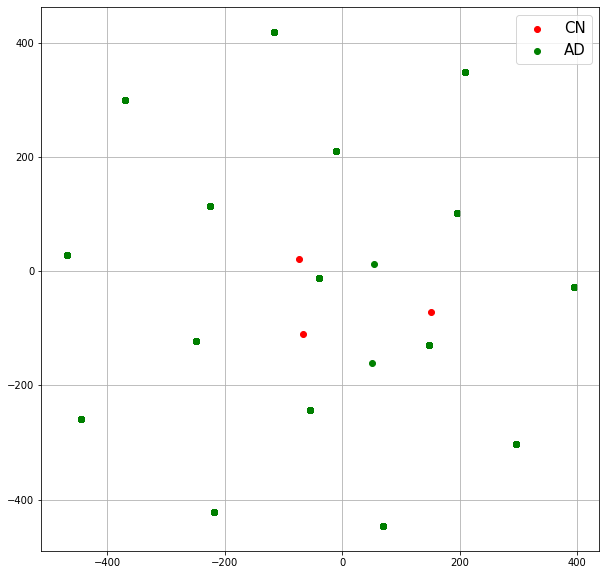

In [14]:
X_embeddeds = np.concatenate(X_embedded_list)
labels = np.concatenate(label_list)
#print(X_embeddeds[labels==0])
#print(labels)
plt.figure(figsize = (10, 10))

plt.scatter(X_embeddeds[labels==0, 0], X_embeddeds[labels==0, 1], c="r", label="CN")
plt.scatter(X_embeddeds[labels==1, 0], X_embeddeds[labels==1, 1], c="g", label="AD")
plt.grid()
plt.legend(fontsize=15)